# Question 2: Peak times for crime occurrances

This notebook aims to answer the second question of the project.

In each year:

- What are the peak times for crime occurences?

- Does it change according to season?

- Is there a concentration of crime around a specific period of the year?

## Initial setup

The dependencies used for this notebook are:

- `Path` from the `pathlib` module: to setup the file paths and make them compatible across operating systems.
- Subclass `CategoricalDtype` from `pandas.api.types` to create cateogrical ordered variables.
- `pandas` module: to prepare the data and generate some of the figures.
- `.pyplot` from the `mathplotlib` module: to generate figures.
- `numpy` module: to generate some of the variables used for formatting.

In [1]:
# Dependencies

from pathlib import Path 
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# for two-way anova

# import statsmodels.api as sm
# from statsmodels.formula.api import ols


Now we read in the data, select the columns we need for the analysis and rename them. We also make the year column a string and convert the columns of Month and Day of the Week into ordered categorical variables, so they keep their order when plotting.

In [2]:
# Read in data
df = pd.read_csv(Path('resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOW', 'OCC_HOUR', 'MCI_CATEGORY', 'OFFENCE']]
    .rename(
        columns={
            'OCC_YEAR': 'Year',
            'OCC_MONTH': 'Month',
            'OCC_DAY': 'Day',
            'OCC_DOW': 'Weekday',
            'OCC_HOUR': 'Hour',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
)


# Make year a string 
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)


# Make month an ordered categorical variable
df['Month'] = (df['Month']
    .astype(
        CategoricalDtype(
            categories=[
                'January',
                'February',
                'March',
                'April',
                'May',
                'June',
                'July',
                'August',
                'September',
                'October',
                'November',
                'December'
            ],
            ordered=True))
)

# Make day of the week an ordered categorical variable
df['Weekday'] = (df['Weekday']
    .str.strip()
    .astype(
        CategoricalDtype(
            categories=[
                'Monday',
                'Tuesday',
                'Wednesday',
                'Thursday',
                'Friday',
                'Saturday',
                'Sunday'
            ],
            ordered=True)
    )
)

df.head()

,Year,Month,Day,Weekday,Hour,Category,Offence
0,2014,January,1.0,Wednesday,3.0,Break and Enter,B&E
1,2014,January,1.0,Wednesday,4.0,Assault,Assault
2,2014,January,1.0,Wednesday,4.0,Theft Over,Theft Over
3,2014,January,1.0,Wednesday,4.0,Assault,Assault
4,2014,January,1.0,Wednesday,2.0,Assault,Assault Bodily Harm


## Calculate daily averages

In [3]:
dates = df[['Year', 'Month', 'Day', 'Weekday']].drop_duplicates()
dates

,Year,Month,Day,Weekday
0,2014,January,1.0,Wednesday
84,2014,January,2.0,Thursday
136,2014,January,3.0,Friday
184,2014,January,4.0,Saturday
239,2014,January,5.0,Sunday
...,...,...,...,...
297925,2022,December,27.0,Tuesday
298025,2022,December,28.0,Wednesday
298130,2022,December,29.0,Thursday
298243,2022,December,30.0,Friday


In [4]:
daily_count = (df
    .groupby(['Year', 'Month', 'Day'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Daily count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
daily_count.head()

,Year,Month,Day,Daily count,Weekday
0,2014,January,1.0,234,Wednesday
1,2014,January,2.0,53,Thursday
2,2014,January,3.0,64,Friday
3,2014,January,4.0,58,Saturday
4,2014,January,5.0,70,Sunday


## By month

In [5]:
df_by_month = (df
    .groupby('Month', as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

df_by_month

,Month,Number of events
0,January,23583
1,February,21289
2,March,23789
3,April,23274
4,May,25505
5,June,25565
6,July,26463
7,August,26249
8,September,25876
9,October,26729


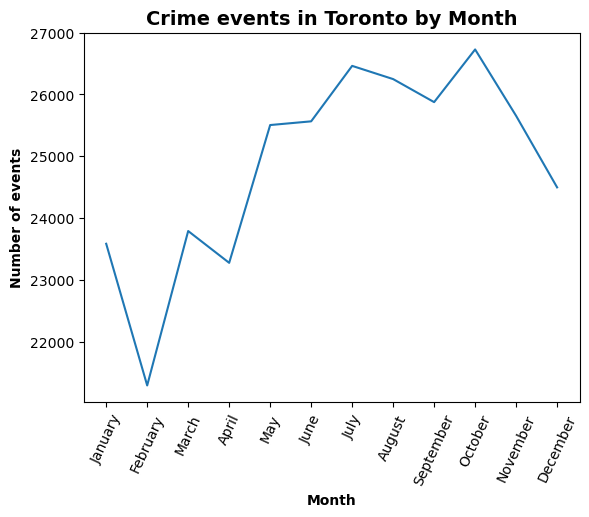

In [6]:
fig, ax = plt.subplots()

ax.plot(
    df_by_month['Month'],
    df_by_month['Number of events']
)

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto by Month',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)


plt.show()

In [7]:
day_av_by_month = (daily_count
    .groupby(['Year', 'Month'], as_index=False)
    .agg(monthly_daily_average=('Daily count', 'mean'))
)
day_av_by_month

,Year,Month,monthly_daily_average
0,2014,January,77.741935
1,2014,February,67.935484
2,2014,March,75.161290
3,2014,April,77.129032
4,2014,May,87.548387
...,...,...,...
103,2022,August,103.612903
104,2022,September,105.645161
105,2022,October,108.516129
106,2022,November,105.645161


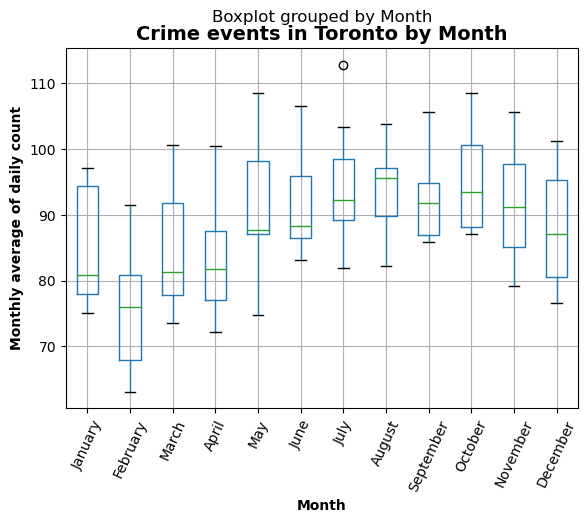

In [8]:
day_av_by_month.boxplot('monthly_daily_average', by='Month')
plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Monthly average of daily count', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto by Month',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)


plt.show()

In [9]:
jan = day_av_by_month.loc[day_av_by_month['Month']=='January']['monthly_daily_average']
feb = day_av_by_month.loc[day_av_by_month['Month']=='February']['monthly_daily_average']
mar = day_av_by_month.loc[day_av_by_month['Month']=='March']['monthly_daily_average']
apr = day_av_by_month.loc[day_av_by_month['Month']=='April']['monthly_daily_average']
may = day_av_by_month.loc[day_av_by_month['Month']=='May']['monthly_daily_average']
jun = day_av_by_month.loc[day_av_by_month['Month']=='June']['monthly_daily_average']
jul = day_av_by_month.loc[day_av_by_month['Month']=='July']['monthly_daily_average']
aug = day_av_by_month.loc[day_av_by_month['Month']=='August']['monthly_daily_average']
sep = day_av_by_month.loc[day_av_by_month['Month']=='September']['monthly_daily_average']
octb = day_av_by_month.loc[day_av_by_month['Month']=='October']['monthly_daily_average']
nov = day_av_by_month.loc[day_av_by_month['Month']=='November']['monthly_daily_average']
dec = day_av_by_month.loc[day_av_by_month['Month']=='December']['monthly_daily_average']

In [10]:
st.f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, octb, nov, dec)

F_onewayResult(statistic=3.9573747172616023, pvalue=9.459993770771641e-05)

In [11]:
# count by category and month
month_category_count = (df
    .groupby(['Month', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

month_category_count.head()

,Month,Category,Number of events
0,January,Assault,12229
1,January,Auto Theft,3026
2,January,Break and Enter,5286
3,January,Robbery,2244
4,January,Theft Over,798


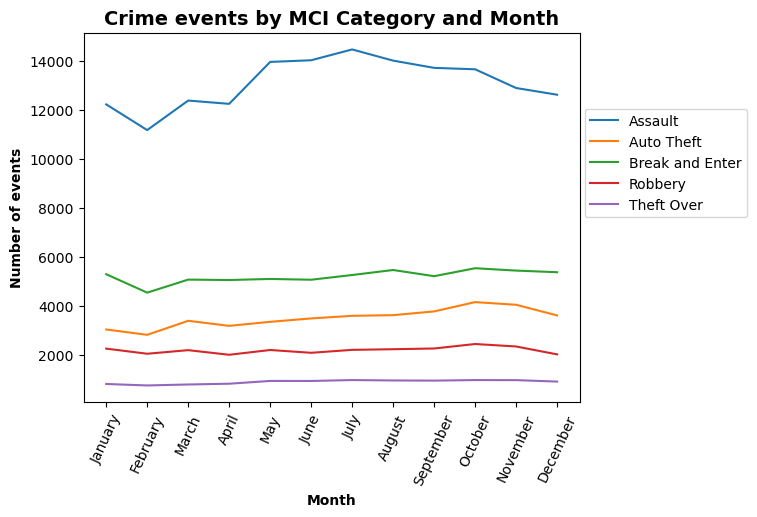

In [12]:
# Visualize

fig, ax = plt.subplots()

mci_cats = list(month_category_count['Category'].unique())

for mci_cat in mci_cats:
    this_data = month_category_count.loc[month_category_count['Category'] == mci_cat]
    # add this category to plot
    ax.plot(
        this_data['Month'],
        this_data['Number of events'],
        label=mci_cat,
        clip_on = False
    )

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by MCI Category and Month',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)
plt.legend(loc=(1.01, 0.5))

plt.show()

## By Year and Month

In [13]:
# # count by year and month
# year_month_count = (df
#     .groupby(['Year', 'Month'], as_index=False)
#     .size()
#     .fillna(0)
#     .rename(columns={'size': 'Number of events'})
# )

# year_month_count['Year Month'] = year_month_count.Month.astype('string') + ' ' + year_month_count.Year

# year_month_count.head()

In [14]:
# # Visualize

# # List of years
# years = list(year_month_count['Year'].unique())

# fig, ax = plt.subplots(figsize=(20,5))

# ax.plot(
#     year_month_count['Year Month'],
#     year_month_count['Number of events']
# )

# plt.xlabel('Month and Year', fontdict={'weight': 700})
# plt.ylabel('Number of events', fontdict={'weight': 700})
# plt.title(
#     'Crime events in Toronto over Time',
#     fontdict={'weight': 700, 'size': 14}
#     )

# plt.xticks(
#     ticks=np.arange(len(year_month_count['Year Month'])),
#     labels=[m[0:3] + ' ' + y[2:4] for m, y in zip(year_month_count['Month'], year_month_count['Year'])],
#     rotation=90
# )

# plt.tight_layout()


# plt.show()

In [15]:
# # count by category, year and month
# year_month_cat_count = (df
#     .groupby(['Year', 'Month', 'Category'], as_index=False)
#     .size()
#     .fillna(0)
#     .rename(columns={'size': 'Number of events'})
# )

# year_month_cat_count['Year Month'] = year_month_cat_count.Month.astype('string') + ' ' + year_month_cat_count.Year

# year_month_cat_count

In [16]:
# # Visualize

# # List of categories
# mci_cats = list(year_month_cat_count['Category'].unique())

# fig, ax = plt.subplots(figsize=(20,5))
# for mci_cat in mci_cats:
#     this_data = year_month_cat_count.loc[year_month_cat_count['Category'] == mci_cat]
#     ax.plot(
#         this_data['Year Month'],
#         this_data['Number of events'],
#         label=mci_cat
#     )

# plt.xlabel('Month and Year', fontdict={'weight': 700})
# plt.ylabel('Number of events', fontdict={'weight': 700})
# plt.title(
#     'Crime events in Toronto over Time',
#     fontdict={'weight': 700, 'size': 14}
#     )

# plt.xticks(
#     ticks=np.arange(len(year_month_count['Year Month'])),
#     labels=[m[0:3] + ' ' + y[2:4] for m, y in zip(year_month_count['Month'], year_month_count['Year'])],
#     rotation=90
# )
# plt.legend(loc='upper left')

# plt.tight_layout()


# plt.show()

## By Day of the Week

In [17]:
df_by_dow = (df
    .groupby('Weekday', as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

df_by_dow

,Weekday,Number of events
0,Monday,41685
1,Tuesday,41093
2,Wednesday,42125
3,Thursday,42258
4,Friday,45135
5,Saturday,43902
6,Sunday,42274


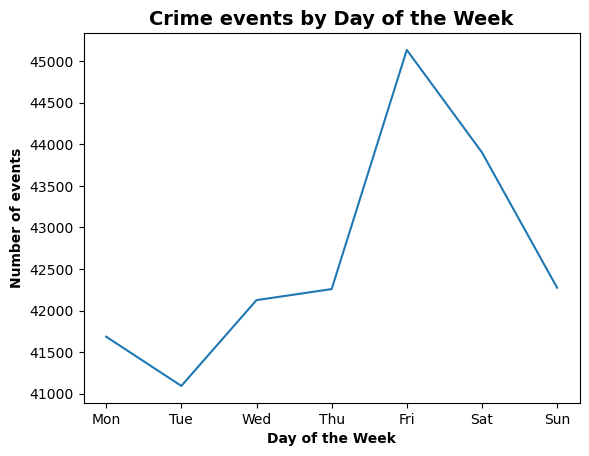

In [18]:
fig, ax = plt.subplots()

ax.plot(
    df_by_dow['Weekday'],
    df_by_dow['Number of events']
)

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in df_by_dow['Weekday']]
)


plt.show()

In [19]:
day_av_by_dow = (daily_count
    .groupby(['Year', 'Month', 'Weekday'], as_index=False)
    .agg(dow_daily_average=('Daily count', 'mean'))
)
day_av_by_dow

,Year,Month,Weekday,dow_daily_average
0,2014,January,Monday,65.00
1,2014,January,Tuesday,75.75
2,2014,January,Wednesday,105.60
3,2014,January,Thursday,70.00
4,2014,January,Friday,81.80
...,...,...,...,...
751,2022,December,Wednesday,94.00
752,2022,December,Thursday,108.60
753,2022,December,Friday,101.60
754,2022,December,Saturday,103.40


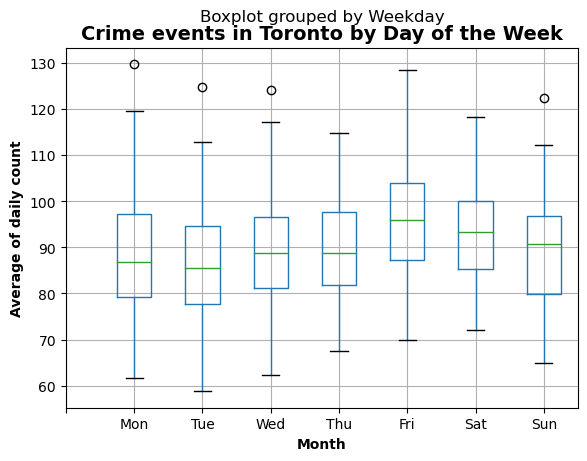

In [20]:
day_av_by_dow.boxplot('dow_daily_average', by='Weekday')
plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto by Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(8),
    labels=['']+[m[0:3] for m in day_av_by_dow['Weekday'][0:7]]
)


plt.show()

In [21]:
mon = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Monday']['dow_daily_average']
tue = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Tuesday']['dow_daily_average']
wed = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Wednesday']['dow_daily_average']
thu = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Thursday']['dow_daily_average']
fri = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Friday']['dow_daily_average']
sat = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Saturday']['dow_daily_average']
sun = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Sunday']['dow_daily_average']

In [22]:
st.f_oneway(mon, tue, wed, thu, fri, sat, sun)

F_onewayResult(statistic=6.780278991460453, pvalue=5.168951176091798e-07)

In [23]:
day_av_by_dow = day_av_by_dow.rename(columns={'Day of the Week': 'Weekday'})
day_av_by_dow.head()

,Year,Month,Weekday,dow_daily_average
0,2014,January,Monday,65.00
1,2014,January,Tuesday,75.75
2,2014,January,Wednesday,105.60
3,2014,January,Thursday,70.00
4,2014,January,Friday,81.80


In [24]:
# Performing two-way ANOVA
# model = ols("dow_daily_average ~ C(Month) + C(Weekday)", data=day_av_by_dow).fit()
# sm.stats.anova_lm(model, typ=3)

In [25]:
# count by category and dow
dow_category_count = (df
                      .groupby(['Weekday', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

dow_category_count.head()

,Weekday,Category,Number of events
0,Monday,Assault,21445
1,Monday,Auto Theft,5967
2,Monday,Break and Enter,9031
3,Monday,Robbery,3674
4,Monday,Theft Over,1568


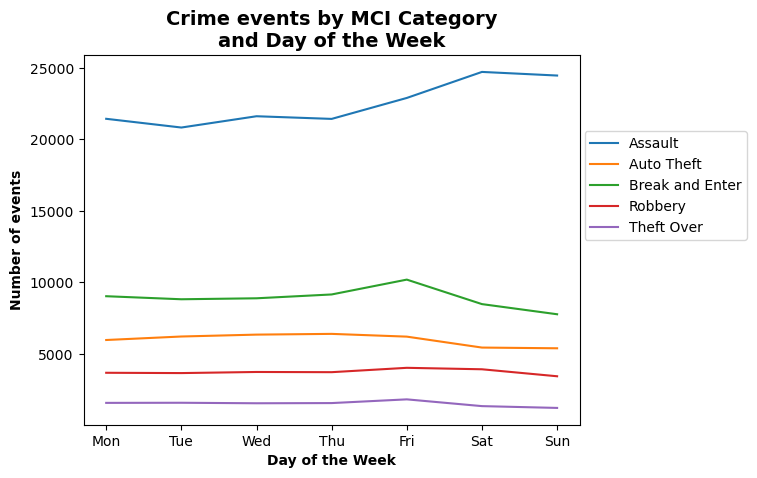

In [26]:
# Visualize

fig, ax = plt.subplots()

for mci_cat in mci_cats:
    this_data = dow_category_count.loc[dow_category_count['Category'] == mci_cat]
    # add this category to plot
    ax.plot(
        this_data['Weekday'],
        this_data['Number of events'],
        label=mci_cat
    )

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by MCI Category\nand Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in df_by_dow['Weekday']]
)
plt.legend(loc=(1.01, 0.5))

plt.show()

In [27]:
# # count by year and dow
# year_dow_count = (df
#                   .groupby(['Year', 'Weekday'], as_index=False)
#     .size()
#     .fillna(0)
#     .rename(columns={'size': 'Number of events'})
# )

# year_dow_count.head()

In [28]:
# # Visualize

# # List of years
# years = list(year_dow_count['Year'].unique())

# fig, ax = plt.subplots(figsize=(7, 5))

# for year in years:
#     this_data = year_dow_count.loc[year_dow_count['Year'] == year]
#     # add this year to the plot
#     ax.plot(
#         this_data['Weekday'],
#         this_data['Number of events'],
#         label=year,
#         clip_on=False
#     )

# plt.xlabel('Day of the Week', fontdict={'weight': 700})
# plt.ylabel('Number of events', fontdict={'weight': 700})
# plt.title(
#     'Crime events by Year and Day of the Week',
#     fontdict={'weight': 700, 'size': 14}
# )

# plt.xticks(
#     ticks=np.arange(7),
#     labels=[m[0:3] for m in df_by_dow['Weekday']]
# )

# plt.legend(loc=(1.01, 0.5))

# plt.show()


## By Hour of Day

In [29]:
df_by_hour = (df
    .dropna()
    .groupby('Hour', as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

df_by_hour.head()

,Hour,Number of events
0,1.0,12175
1,2.0,11897
2,3.0,9894
3,4.0,7888
4,5.0,6176


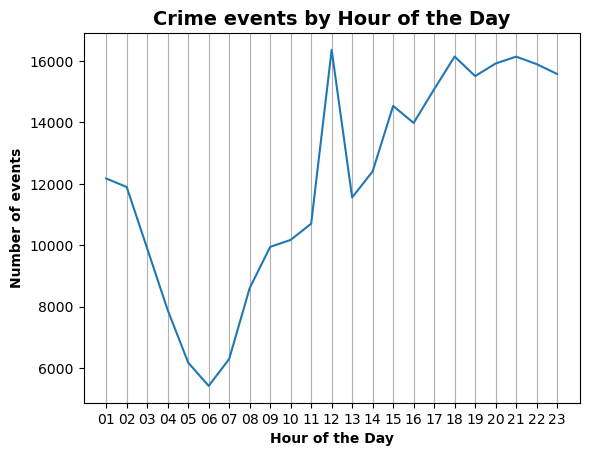

In [30]:
fig, ax = plt.subplots()

ax.plot(
    df_by_hour['Hour'],
    df_by_hour['Number of events']
)

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by Hour of the Day',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(1, 24),
    labels=[str(n).zfill(2) for n in np.arange(1, 24)]
)
plt.grid(True, which='both', axis='x')

plt.show()

In [31]:
# count by category and hour
hour_category_count = (df
    .groupby(['Hour', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

hour_category_count.head()

,Hour,Category,Number of events
0,1.0,Assault,6389
1,1.0,Auto Theft,1459
2,1.0,Break and Enter,2800
3,1.0,Robbery,1285
4,1.0,Theft Over,242


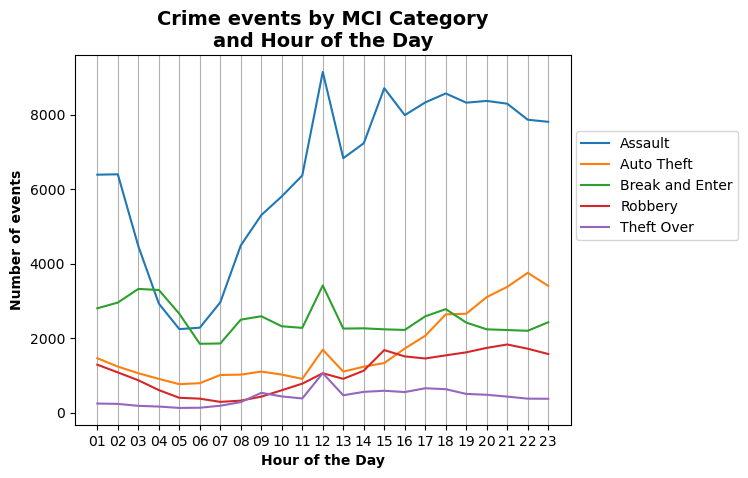

In [32]:
# Visualize

fig, ax = plt.subplots()

for mci_cat in mci_cats:
    this_data = hour_category_count.loc[hour_category_count['Category'] == mci_cat]
    # add this category to the plot
    ax.plot(
        this_data['Hour'],
        this_data['Number of events'],
        label=mci_cat,
        clip_on = False
    )

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by MCI Category\nand Hour of the Day',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(1,24),
    labels=[str(n).zfill(2) for n in np.arange(1,24)]
)
plt.legend(loc=(1.01, 0.5))
plt.grid(True, which='both', axis='x')


plt.show()

In [33]:
# # count by year and dow
# year_hour_count = (df
#     .groupby(['Year', 'Hour'], as_index=False)
#     .size()
#     .fillna(0)
#     .rename(columns={'size': 'Number of events'})
# )

# year_hour_count.head()

In [34]:
# # Visualize

# fig, ax = plt.subplots(figsize=(7, 5))

# for year in years:
#     this_data = year_hour_count.loc[year_hour_count['Year'] == year]
#     # add this category to plot
#     ax.plot(
#         this_data['Hour'],
#         this_data['Number of events'],
#         label=year,
#         clip_on=False
#     )

# plt.xlabel('Hour of the Day', fontdict={'weight': 700})
# plt.ylabel('Number of events', fontdict={'weight': 700})
# plt.title(
#     'Crime events by Year and Hour of the Day',
#     fontdict={'weight': 700, 'size': 14}
# )

# plt.xticks(
#     ticks=np.arange(1, 24),
#     labels=[str(n).zfill(2) for n in np.arange(1, 24)]
# )
# plt.grid(True, which='both', axis='x')

# plt.legend(loc=(1.01, 0.5))

# plt.show()
